### Document Enrichment 
- Translation of Language
- Medical Insights

In [1]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [2]:
!pip install amazon-textract-response-parser

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

### Translate Langugae

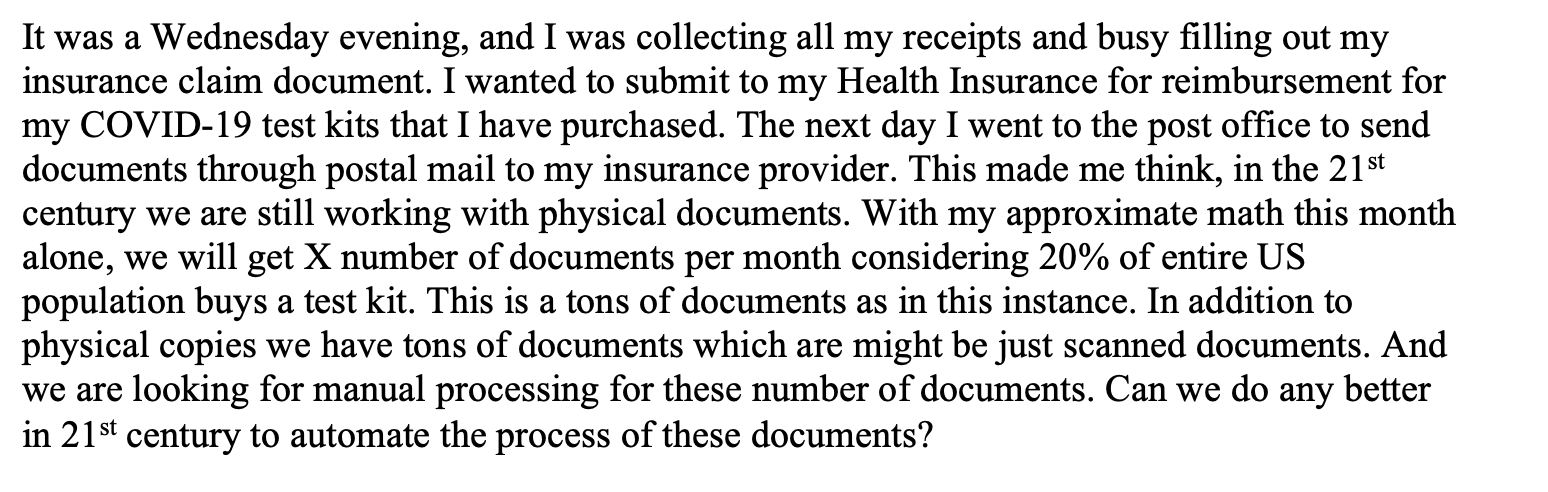

In [15]:
# Document
documentName = "syncdensetext.png"
display(Image(filename=documentName))


In [17]:
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
textract = boto3.client('textract')
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])


It was a Wednesday evening, and I was collecting all my receipts and busy filling out my
insurance claim document. I wanted to submit to my Health Insurance for reimbursement for
my COVID-19 test kits that I have purchased. The next day I went to the post office to send
documents through postal mail to my insurance provider. This made me think, in the 21 st
century we are still working with physical documents. With my approximate math this month
alone, we will get X number of documents per month considering 20% of entire US
population buys a test kit. This is a tons of documents as in this instance. In addition to
physical copies we have tons of documents which are might be just scanned documents. And
we are looking for manual processing for these number of documents. Can we do any better
in 21st century to automate the process of these documents?


In [20]:
# Amazon Translate client
translate = boto3.client('translate')

print ('')
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        result = translate.translate_text(Text=item["Text"], SourceLanguageCode="en", TargetLanguageCode="de")
        print ('\033[92m' + result.get('TranslatedText') + '\033[0m')
    print ('')




It was a Wednesday evening, and I was collecting all my receipts and busy filling out my
Es war ein Mittwochabend, und ich sammelte alle meine Quittungen ab und füllte meine

insurance claim document. I wanted to submit to my Health Insurance for reimbursement for
Dokument für Versicherungsansprüche. Ich wollte bei meiner Krankenversicherung eine Erstattung beantragen

my COVID-19 test kits that I have purchased. The next day I went to the post office to send
meine COVID-19-Testkits, die ich gekauft habe. Am nächsten Tag ging ich zur Post, um zu schicken

documents through postal mail to my insurance provider. This made me think, in the 21 st
Dokumente per Post an meine Versicherung. Das brachte mich zum Nachdenken, im 21.

century we are still working with physical documents. With my approximate math this month
Jahrhundert arbeiten wir immer noch mit physischen Dokumenten. Mit meiner ungefähren Mathematik in diesem Monat

alone, we will get X number of documents per month considerin

# Sample Document

30 fields. 2 fileds are optional [ local use, xxx]
member id field is a mandatory field

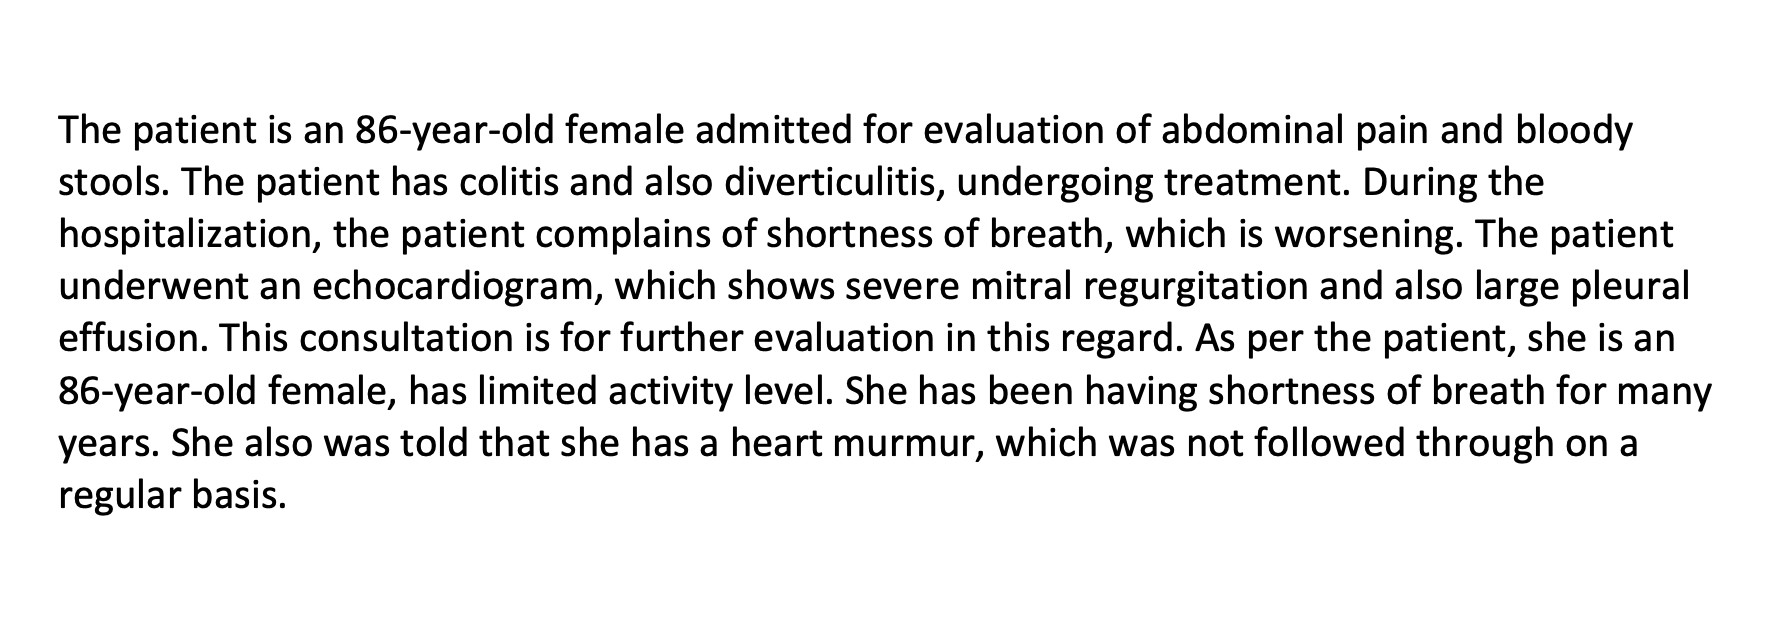

In [4]:
# Document

documentName = "doctornotes1.png"

display(Image(filename=documentName))

# Data Extraction

In [5]:
# process using image bytes
def calltextract(documentName): 
    client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [6]:
response= calltextract(documentName)
print(response)

Image loaded doctornotes1.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 3.97788971895352e-05}, {'X': 0.9999349117279053, 'Y': 0.0}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0004315438854973763, 'Y': 1.0}]}, 'Id': '2563e51d-3f3c-4e23-a668-cd0f8ebcf4a5', 'Relationships': [{'Type': 'CHILD', 'Ids': ['fc0cf05e-b45f-450e-998c-dd24dca4c28d', '6e20172c-8287-426b-aa37-1c6a3b514d77', '87bb59f0-dc63-49f3-ab7b-4da92b97c3b5', '9cd5aac7-6b9a-4e0f-af6a-65d3fa13b44b', 'f34428b7-1f4f-4c80-91c0-123f22775f12', '520a3bd3-ace5-417f-9514-81fc25cf3790', 'fa435c0b-91c6-4eb5-b37d-097b72167c63', 'a5e998ac-8db6-439f-b49b-5c2ef24aa94d']}]}, {'BlockType': 'LINE', 'Confidence': 99.9679946899414, 'Text': 'The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody', 'Geometry': {'BoundingBox': {'Width': 0.8848024606704712, 'Height': 0.06508300453424454, 'Left': 

In [7]:
# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text = text + " " + item["Text"]
        
        
print(text)

 The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion. This consultation is for further evaluation in this regard. As per the patient, she is an 86-year-old female, has limited activity level. She has been having shortness of breath for many years. She also was told that she has a heart murmur, which was not followed through on a regular basis.


In [8]:
# Call Comprehend Medical
comprehendmedical = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehendmedical.detect_entities_v2(Text=text)

print("\nMedical Condition\n========")
for entity in cm_json_data["Entities"]:

    if entity["Category"] == "MEDICAL_CONDITION":
        print(entity["Text"])

print("\nAnatomy\n========")
for entity in cm_json_data["Entities"]:     

    if entity["Category"] == "ANATOMY":
        print(entity["Text"])
        
print("\nTest Treatment Procedure\n========")
for entity in cm_json_data["Entities"]:     

    if entity["Category"] == "TEST_TREATMENT_PROCEDURE":
        print(entity["Text"])
        

    



Medical Condition
pain
bloody stools
colitis
diverticulitis
shortness of breath
mitral regurgitation
effusion
limited activity level
shortness of breath
murmur

Anatomy
abdominal
mitral
pleural
heart

Test Treatment Procedure
evaluation
treatment
echocardiogram


### Medication and Doasage with RxNorm

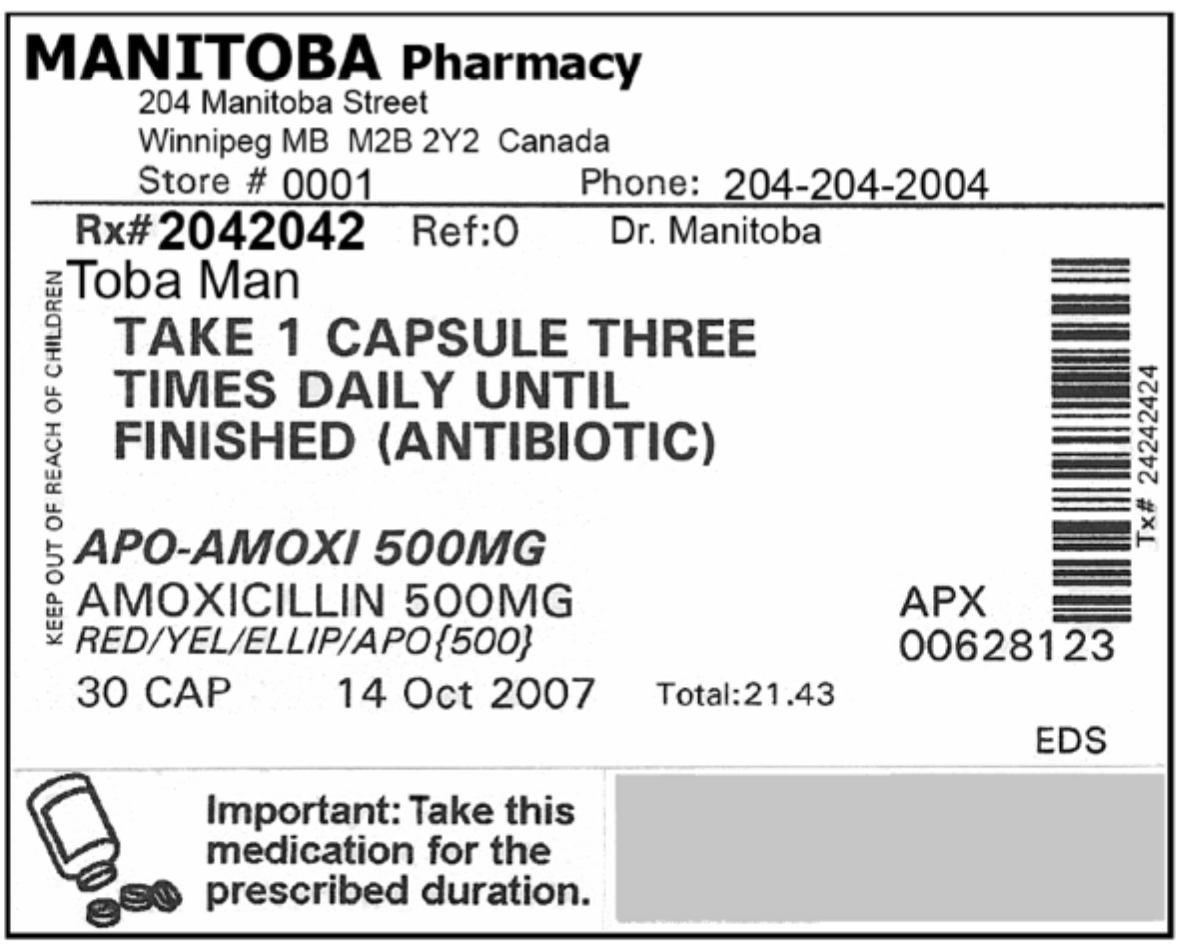

In [9]:
documentName = "prescription.png"
display(Image(filename=documentName))

In [10]:

response= calltextract(documentName)
#print(response)

# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text = text + " " + item["Text"]
        
        
print(text)

Image loaded prescription.png
 MANITOBA Pharmacy 204 Manitoba Street Winnipeg MB M2B 2Y2 Canada Store # 0001 Phone: 204-204-2004 Rx#2042042 Ref:0 Dr. Manitoba Toba Man TAKE 1 CAPSULE THREE TIMES DAILY UNTIL FINISHED (ANTIBIOTIC) APO-AMOXI 500MG AMOXICILLIN 500MG APX RED/YEL/ELLIP/APO{500} 00628123 30 CAP 14 Oct 2007 Total:21.43 EDS ! Important: Take this medication for the prescribed duration.


In [11]:
# Call Comprehend Medical
comprehendmedical = boto3.client(service_name='comprehendmedical')
# Detect medical entities


cm_json_data =  comprehendmedical.detect_entities_v2(Text=text)
print("MEDICATION LIST\n")
for entity in cm_json_data["Entities"]:

    if entity["Category"] == "MEDICATION":
        print(entity["Text"])
        for key in entity:
            Attribute_List = []
            if key == 'Attributes':
                for r in entity[key]:
                        Attribute_List.append(r['Type']+':'+r['Text'])
        print(str(Attribute_List))
        

MEDICATION LIST

APO-AMOXI
['DOSAGE:500MG', 'STRENGTH:500MG', 'FORM:CAP']
AMOXICILLIN
['STRENGTH:500MG', 'FORM:CAP']


In [12]:

cm_json_data =  comprehendmedical.infer_rx_norm(Text=text)

print("\n RxNorm Code\n========")

for entity in cm_json_data["Entities"]:
    
    for rx in entity["RxNormConcepts"]:
        print(rx['Code'])
            



 RxNorm Code
1661017
1551571
2591813
900048
852494
308191
308212
308192
723
1721474


## ICD 10 CM Code

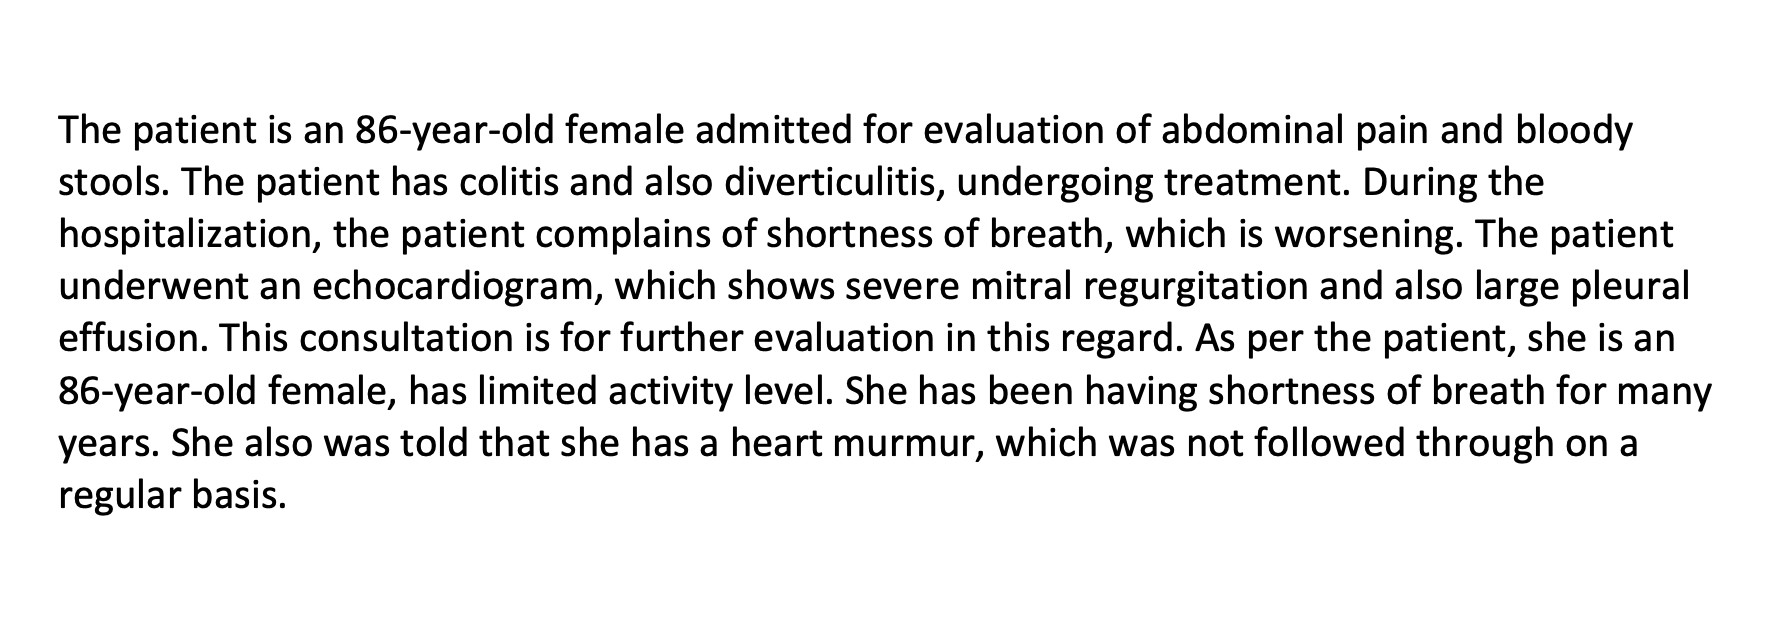

Image loaded doctornotes1.png
 The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion. This consultation is for further evaluation in this regard. As per the patient, she is an 86-year-old female, has limited activity level. She has been having shortness of breath for many years. She also was told that she has a heart murmur, which was not followed through on a regular basis.


In [13]:
# Document

documentName = "doctornotes1.png"

display(Image(filename=documentName))
response= calltextract(documentName)
#print(response)

# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text = text + " " + item["Text"]
        
        
print(text)

In [14]:
cm_json_data =  comprehendmedical.infer_icd10_cm(Text=text)

print("\n Medical coding\n========")

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        
        if (icd["Score"] >= 0.93):
            code = icd["Code"]
            print(code)
            



 Medical coding
R06.02
R01.1


### End

Delete the Amazon s3 bucket and the files in the buckethttps://docs.aws.amazon.com/AmazonS3/latest/userguide/delete-bucket.html